<a href="https://colab.research.google.com/github/pramudyadika/Tugas-Akhir-Big-Data-dan-Analitik/blob/main/Tugas_Akhir_Kelompok_BDA_Text_Mining_dan_Sentiment_Analysis_Wisata_Kota_Jogja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TEXT MINING DAN SENTIMENT ANALYSIS WISATA KOTA JOGJA PADA MEDIA SOSIAL TWITTER**

### **Anggota Kelompok:**
1. Ariq Tsaqif Aryasuta (20/460541/TK/51130)
3. Pramudya Kusuma Hardika (20/460558/TK/51147)
2. Danurrizad Ryan Darmoko (20/463597/TK/51589)


>Pariwisata merupakan salah satu sektor vital dalam ekonomi Indonesia, terutama di Yogyakarta yang kaya akan alam dan budaya. Media sosial memegang peran kunci dalam mempromosikan destinasi wisata, khususnya di Kota Jogja. Oleh karena itu, proyek ini akan fokus pada analisis tren wisata di Kota Jogja melalui media sosial Twitter, dengan penekanan pada metode text mining dan analisis sentimen.

> Teknik text mining akan membantu menggali wawasan mendalam dari data teks yang tersebar di Twitter terkait wisata di Kota Jogja. Sedangkan, analisis sentimen akan memberikan pemahaman tentang pandangan dan opini wisatawan terhadap destinasi wisata Kota Jogja yang tercermin dalam konten media sosial.

###**1. Meng-import Library**



> Melakukan instalasi dan mengimport library yang akan digunakan dalam project kali ini



In [ ]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install wordcloud
!pip install Sastrawi
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.4 MB/s eta 0:00:00


In [ ]:
import gc
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from wordcloud import WordCloud

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
from collections import Counter

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import locale
locale.getpreferredencoding = lambda: "UTF-8"

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, TextClassificationPipeline

# ignore warning
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###**2. Melakukan Load dataset ke dataframe**

In [ ]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Dataframe untuk tweets terkait wisata jogja
dfjogjawis = pd.read_csv("drive/MyDrive/BDA/wisatajogja_twt.csv")

# Dataframe untuk tweets dengan tag untuk tiap-tiap nama wisata yang ada di jogja kota saja
dfwisata = pd.read_csv("drive/MyDrive/BDA/twtWisataKota.csv")

Pada project ini digunakan dua dataset hasil scraping dari Twitter dengan deskripsi singkat sebagai berikut:

*   dfjogjawis: dataset yang berisikan tweet yang mengandung keyword 'wisata jogja'
*   dfwisata: dataset yang berisikan tweet yang mengandung keyword nama-nama tempat wisata yang ada di Kota Yogya

Dataset dapat diakses pada [link berikut ini](https://drive.google.com/drive/folders/1JP1Kk7pVnNutYrH4-HEzlhB2A1sVxmkG?usp=sharing).


> Me-rename nama kolom ke bentuk standar



In [ ]:
dfjogjawis = dfjogjawis.rename(columns={'ID': 'id', 'User': 'user', 'Date Created': 'date_created', 'Number of Likes': 'likes', 'Source of Tweet': 'source', 'Tweet': 'tweet'})
dfwisata = dfwisata.rename(columns={'ID': 'id', 'User': 'user', 'Date Created': 'date_created', 'Number of Likes': 'likes', 'Source of Tweet': 'source', 'Tweet': 'tweet', 'Tagname': 'tag'})


> Menyesuaikan format untuk *Datetime*


In [ ]:
#Format waktu agar hanya sensitif sampai jam saja
dfjogjawis['date_created'] = pd.to_datetime(dfjogjawis['date_created'])
dfjogjawis['date_time'] = dfjogjawis['date_created'].apply(lambda x: x.replace(minute=0, second=0))
dfjogjawis.drop(['date_created'], axis=1, inplace=True)

dfwisata['date_created'] = pd.to_datetime(dfwisata['date_created'])
dfwisata['date_time'] = dfwisata['date_created'].apply(lambda x: x.replace(minute=0, second=0))
dfwisata.drop(['date_created'], axis=1, inplace=True)

In [ ]:
dfjogjawis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19585 entries, 0 to 19584
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         19585 non-null  int64              
 1   user       19585 non-null  object             
 2   likes      19585 non-null  int64              
 3   source     19585 non-null  object             
 4   tweet      19585 non-null  object             
 5   date_time  19585 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 918.2+ KB


In [ ]:
dfjogjawis.head(5)

,id,user,likes,source,tweet,date_time
0,0,ajeng_ol,0,Twitter for Android,Dari awal gue emang ga setuju sama konsep ni w...,2022-01-29 22:00:00+00:00
1,1,afaninula,0,Twitter for Android,dipikir2 tiap ke jogja jarang main ke tempat w...,2022-01-29 18:00:00+00:00
2,2,JogjaCTour,0,twittbot.net,Wisata Alam Curug Sidoharjo https://t.co/k8L67...,2022-01-29 17:00:00+00:00
3,3,ddooun,0,Twitter for Android,Ini ke jogja jatuhnya jadi wisata kuliner😂 bel...,2022-01-29 17:00:00+00:00
4,4,JogjaCTour,0,twittbot.net,Wisata Alam Kebun Buah Mangunan https://t.co/M...,2022-01-29 16:00:00+00:00


In [ ]:
dfwisata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35368 entries, 0 to 35367
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         35368 non-null  int64              
 1   user       35368 non-null  object             
 2   likes      35368 non-null  int64              
 3   source     35368 non-null  object             
 4   tweet      35368 non-null  object             
 5   tag        35368 non-null  object             
 6   date_time  35368 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
dfwisata.head(5)

,id,user,likes,source,tweet,tag,date_time
0,1,IpkaniM,1,Twitter for Android,"Rabu (21/12/22), Melaksanakan kegiatan pendamp...",Bangsal Kencana,2022-12-22 03:00:00+00:00
1,2,AchmadHmdM94,0,Twitter for Android,@plusminusdua Pameran nya cuma dikit kok kayak...,Bangsal Kencana,2022-10-31 08:00:00+00:00
2,3,etnopilgrim,2,Twitter for Android,Didalam Cepuri Kotagedhe terdapat beberapa ban...,Bangsal Kencana,2022-10-18 09:00:00+00:00
3,4,tasteofjogja,1,Twitter Web App,Regol Gapura\n\nRegol Gapura merupakan gerbang...,Bangsal Kencana,2022-10-04 08:00:00+00:00
4,5,rotenuts,175,Twitter for Android,"@convomfs mamaku sih yg cerita, wktu papaku di...",Bangsal Kencana,2022-07-01 06:00:00+00:00


###**3. Data Preprocessing**

In [ ]:
print(dfjogjawis.shape)
print(dfwisata.shape)

(19585, 6)
(35368, 7)


> **Row Preprocessing**





*   Menghapus baris yang dianggap duplikat(spam/bot) berdasar atribut user, tweet, and date.



In [ ]:
# Membuat kolom *dummy* yaitu date agar duplikasi yang dihapus adalah tweet yang sama yang dikirim oleh user yang sama dalam satu hari
dfjogjawis['date'] = pd.to_datetime(dfjogjawis['date_time']).dt.date
dfwisata['date'] = pd.to_datetime(dfwisata['date_time']).dt.date

In [ ]:
print("number of duplicate rows dfjogjawis: ", dfjogjawis[dfjogjawis.duplicated(['user', 'tweet','date'])].shape)
dfjojgawis = dfjogjawis.drop_duplicates(['user', 'tweet','date'])

print("number of duplicate rows dfwisata: ", dfwisata[dfwisata.duplicated(['user', 'tweet','date'])].shape)
dfwisata = dfwisata.drop_duplicates(['user', 'tweet','date'])

# Menghapus lagi kolom date yang dipakai sebagai dummy atribut
dfjogjawis.drop(['date'], axis=1, inplace=True)
dfwisata.drop(['date'], axis=1, inplace=True)

number of duplicate rows dfjogjawis:  (2620, 7)
number of duplicate rows dfwisata:  (1792, 8)


*   Mengecek dan menghapus baris yang memiliki nilai Null (jika ada)

In [ ]:
dfjogjawis.isnull().sum()

id           0
user         0
likes        0
source       0
tweet        0
date_time    0
dtype: int64

In [ ]:
dfwisata.isnull().sum()

id           0
user         0
likes        0
source       0
tweet        0
tag          0
date_time    0
dtype: int64


> **Column Preprocessing**


*   Menghapus atribut **user** untuk semua dataframe karena identitas tidak mempengaruhi hasil

In [ ]:
dfjogjawis.drop(['user'], axis=1, inplace=True)
dfwisata.drop(['user'], axis=1, inplace=True)

In [ ]:
dfjogjawis.head(5)

,id,likes,source,tweet,date_time
0,0,0,Twitter for Android,Dari awal gue emang ga setuju sama konsep ni w...,2022-01-29 22:00:00+00:00
1,1,0,Twitter for Android,dipikir2 tiap ke jogja jarang main ke tempat w...,2022-01-29 18:00:00+00:00
2,2,0,twittbot.net,Wisata Alam Curug Sidoharjo https://t.co/k8L67...,2022-01-29 17:00:00+00:00
3,3,0,Twitter for Android,Ini ke jogja jatuhnya jadi wisata kuliner😂 bel...,2022-01-29 17:00:00+00:00
4,4,0,twittbot.net,Wisata Alam Kebun Buah Mangunan https://t.co/M...,2022-01-29 16:00:00+00:00


In [ ]:
dfwisata.head(5)

,id,likes,source,tweet,tag,date_time
0,1,1,Twitter for Android,"Rabu (21/12/22), Melaksanakan kegiatan pendamp...",Bangsal Kencana,2022-12-22 03:00:00+00:00
1,2,0,Twitter for Android,@plusminusdua Pameran nya cuma dikit kok kayak...,Bangsal Kencana,2022-10-31 08:00:00+00:00
2,3,2,Twitter for Android,Didalam Cepuri Kotagedhe terdapat beberapa ban...,Bangsal Kencana,2022-10-18 09:00:00+00:00
3,4,1,Twitter Web App,Regol Gapura\n\nRegol Gapura merupakan gerbang...,Bangsal Kencana,2022-10-04 08:00:00+00:00
4,5,175,Twitter for Android,"@convomfs mamaku sih yg cerita, wktu papaku di...",Bangsal Kencana,2022-07-01 06:00:00+00:00


In [ ]:
print(dfjogjawis.shape)
print(dfwisata.shape)

(19585, 5)
(33576, 6)


###**4. Case Folding**



> Akan dilakukan cleaning terhadap data tweets yang meliputi :



*   Membuat teks dalam huruf kecil semua (mengganti huruf kapital)
*   Menghilangkan teks yang ada di dalam kurung
*   Menghilangkan teks yang berupa link
*   Menghilangkan tanda baca
*   Menghilangkan kata yang mengandung angka

In [ ]:
def clean_text(text):

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
dfjogjawis['tweet'] = dfjogjawis['tweet'].apply(lambda x:clean_text(x))
dfwisata['tweet'] = dfwisata['tweet'].apply(lambda x:clean_text(x))

In [ ]:
# Melakukan tokenisasi tiap kata untuk tweet dan menyimpannya ke kolom baru yang kita namakan temp_list
dfjogjawis['temp_list'] = dfjogjawis['tweet'].apply(lambda x:str(x).split())
dfwisata['temp_list'] = dfwisata['tweet'].apply(lambda x:str(x).split())

Contoh untuk most common word pada dataframe jogjawis

In [ ]:
print("Jogjawis Most Common Word".center(24," "))
top = Counter([item for sublist in dfjogjawis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

Jogjawis Most Common Word


,Common_words,count
0,wisata,20283
1,jogja,16343
2,di,8852
3,yogyakarta,4187
4,dan,3932
5,yang,3482
6,tempat,3425
7,ke,3367
8,traveling,3212
9,alam,3045


Dapat terlihat bahwa hasil kata diatas masih dipenuhi dengan kata yang disebut 'stopwords', yaitu kata yang seharusnya diabaikan dalam pemrosesan bahasa alami karena tidak memiliki nilai informasi apapun terhadap sentimen analisis kita nantinya. Contohnya adalah di, dan, yang, ini, dst



> **Melakukan Cleaning Stopwords**



In [ ]:
indonesian_stopwords = stopwords.words('indonesian')
indonesian_stopwords.append('yg')                                           #karena yg adalah tulisan gaul yang artinya yang
print(len(indonesian_stopwords), "stopwords:", indonesian_stopwords)

def remove_stopword(x):
    return [y for y in x if y not in indonesian_stopwords]

759 stopwords: ['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak',

In [ ]:
dfjogjawis['temp_list'] = dfjogjawis['temp_list'].apply(lambda x:remove_stopword(x))
dfwisata['temp_list'] = dfwisata['temp_list'].apply(lambda x:remove_stopword(x))

* Hasil most common word word untuk kedua dataframe

In [ ]:
print("Dataframe Jogjawis".center(24," "))
top = Counter([item for sublist in dfjogjawis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

   Dataframe Jogjawis   


,Common_words,count
0,wisata,20283
1,jogja,16343
2,yogyakarta,4187
3,traveling,3212
4,alam,3045
5,guide,2582
6,jogjacitytour,2555
7,jelajah,1870
8,curug,1723
9,diy,1564


In [ ]:
dfjogjawis.head(5)

,id,likes,source,tweet,date_time,temp_list
0,0,0,Twitter for Android,dari awal gue emang ga setuju sama konsep ni w...,2022-01-29 22:00:00+00:00,"[gue, emang, ga, setuju, konsep, ni, wisata, j..."
1,1,0,Twitter for Android,tiap ke jogja jarang main ke tempat wisata hi...,2022-01-29 18:00:00+00:00,"[jogja, jarang, main, wisata, hits, banyakan, ..."
2,2,0,twittbot.net,wisata alam curug sidoharjo jogjacitytour jo...,2022-01-29 17:00:00+00:00,"[wisata, alam, curug, sidoharjo, jogjacitytour..."
3,3,0,Twitter for Android,ini ke jogja jatuhnya jadi wisata kuliner😂 bel...,2022-01-29 17:00:00+00:00,"[jogja, jatuhnya, wisata, kuliner😂, wisatawisa..."
4,4,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-01-29 16:00:00+00:00,"[wisata, alam, kebun, buah, mangunan, jogjacit..."


In [ ]:
print("Dataframe Wisata".center(24," "))
top = Counter([item for sublist in dfwisata['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Reds')

    Dataframe Wisata    


,Common_words,count
0,malioboro,9976
1,tamansari,5530
2,artjog,4977
3,taman,4623
4,sari,4199
5,pasar,3868
6,jogja,3859
7,kembang,3292
8,museum,2456
9,jalan,2411


In [ ]:
dfwisata.head(5)

,id,likes,source,tweet,tag,date_time,temp_list
0,1,1,Twitter for Android,rabu melaksanakan kegiatan pendampingan penge...,Bangsal Kencana,2022-12-22 03:00:00+00:00,"[rabu, melaksanakan, kegiatan, pendampingan, p..."
1,2,0,Twitter for Android,plusminusdua pameran nya cuma dikit kok kayak ...,Bangsal Kencana,2022-10-31 08:00:00+00:00,"[plusminusdua, pameran, nya, dikit, kayak, ker..."
2,3,2,Twitter for Android,didalam cepuri kotagedhe terdapat beberapa ban...,Bangsal Kencana,2022-10-18 09:00:00+00:00,"[didalam, cepuri, kotagedhe, bangunan, mandung..."
3,4,1,Twitter Web App,regol gapuraregol gapura merupakan gerbang den...,Bangsal Kencana,2022-10-04 08:00:00+00:00,"[regol, gapuraregol, gapura, gerbang, lapis, g..."
4,5,175,Twitter for Android,convomfs mamaku sih yg cerita wktu papaku dira...,Bangsal Kencana,2022-07-01 06:00:00+00:00,"[convomfs, mamaku, sih, cerita, wktu, papaku, ..."


###**5. Visualization**



> Berdasarkan dataframe *jogjawis*, bisa kita lihat bahwa karena data tidak spesifik dan cukup luas cakupannya, maka kita akan mengenalkan tipe wisata yang akan menjadi 'tag' dari data-data tersebut



In [ ]:
#List untuk daftar keyword
listWisata = ['gunung', 'pantai', 'danau', 'hutan', 'taman', 'air terjun', 'goa', 'bukit', 'lembah', 'kebun', 'taman nasional',               #Wisata Alam
              'candi', 'kuil', 'museum', 'monumen', 'cagar budaya', 'cagar alam', 'benteng', 'galeri seni', 'desa wisata', 'kampung wisata'   #Wisata Sejarah dan Budaya
              'kolam renang', 'waterpark', 'kebun binatang', 'taman bermain',                                                                 #Wisata Keluarga
              'arung jeram', 'mendaki gunung', 'hiking', 'paralayang', 'surfing', 'rafting', 'camping']                                       #Wisata Petualangan


#Temp_list hanya menyimpan 1 keyword saja, maka dibuat list untuk melakukan join pada kata berdekatan pada tiap tweet
listCombine = [['air','terjun'], ['taman','nasional'], ['cagar','budaya'], ['cagar','alam'],
               ['galeri','seni'], ['kolam','renang'], ['kebun','binatang'], ['taman','bermain'],
               ['arung','jeram'], ['mendaki','gunung']]

In [ ]:
# Definisi fungsi untuk melakukan join kedua kata yang berdekatan pada temp_list
def combine(List1,List2):
  for key in List1:
    bin = []
    ind = 0
    while ind<(len(List2)-1):
      temp = [List2[ind],List2[ind+1]]
      if temp == key:
        List2.append(List2[ind]+' '+List2[ind+1])
        bin.append(List2[ind]) if List2[ind] not in bin else bin
        bin.append(List2[ind+1]) if List2[ind+1] not in bin else bin
      ind=ind+1
    for trash in bin:
      List2.remove(trash)
  return List2


# Definisi fungsi untuk mendeteksi apakah salah satu atau lebih kata pada listWisata ada dalam tweet
def tagging(List1, List2):
  temp = []
  for item in List1:
    for key in List2:
      if item == key:
        temp.append(item) if item not in temp else temp
  return temp

In [ ]:
# dfJogjawis
# Combine

for ind in dfjogjawis.index:
  dfjogjawis['temp_list'][ind] = combine(listCombine,dfjogjawis['temp_list'][ind])

# Membuat kolom baru
dfjogjawis['taglist'] = [[] for _ in range(len(dfjogjawis))]

# Tagging
for ind in dfjogjawis.index:
  taglist = tagging(listWisata, dfjogjawis['temp_list'][ind])
  if dfjogjawis is not None :
    dfjogjawis['taglist'][ind] = taglist

In [ ]:
#drop temp_list karena sudah tidak dibutuhkan
dfjogjawis.drop(['temp_list'], axis=1, inplace=True)
dfwisata.drop(['temp_list'], axis=1, inplace=True)



> Melihat visualisasi dari dataframe dfjogjawis



In [ ]:
print("Dataframe Jogjawis".center(24," "))
top = Counter([item for sublist in dfjogjawis['taglist'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['new_tag','count']
temp.style.background_gradient(cmap='Blues')

   Dataframe Jogjawis   


,new_tag,count
0,pantai,961
1,kebun,911
2,goa,358
3,taman,354
4,gunung,340
5,candi,338
6,bukit,225
7,museum,212
8,hutan,124
9,camping,116


In [ ]:
for i in range(len(listWisata)):
  a = []
  a.append(listWisata[i])
  listWisata[i] = a

In [ ]:
isWisata = 0
isNotWisata = 0
for lst in dfjogjawis['taglist']:
    if not lst:
        isNotWisata += 1
    else:
        isWisata += 1

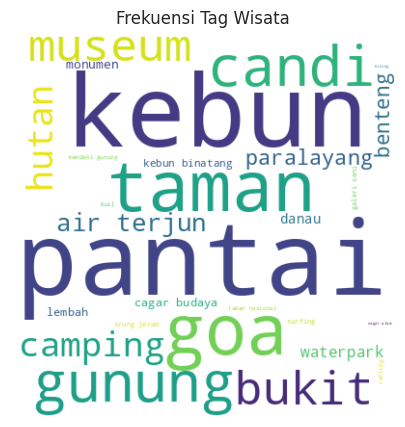

In [ ]:
# Create WordCloud
wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(top))

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frekuensi Tag Wisata')
plt.show()




> dari dataframe *dfWisata* kita bisa melihat beberapa insight yang dimiliki oleh data kita sebagai berikut



In [ ]:
# calculate the total likes of each tag value
dflikes = dfwisata.groupby(["tag"]).sum()
dflikes['likes'] = dflikes.groupby(["tag"]).mean()['likes']

dflikes.drop(['id'], axis=1, inplace=True)
dflikes = dflikes.sort_values('likes', ascending=False)

In [ ]:
dflikes.head(5)

,likes
tag,
Artjog,73503.0
Malioboro,60221.0
Gembira Loka,27882.0
Taman Sari,25826.0
Masjid Gedhe Kauman,16109.0


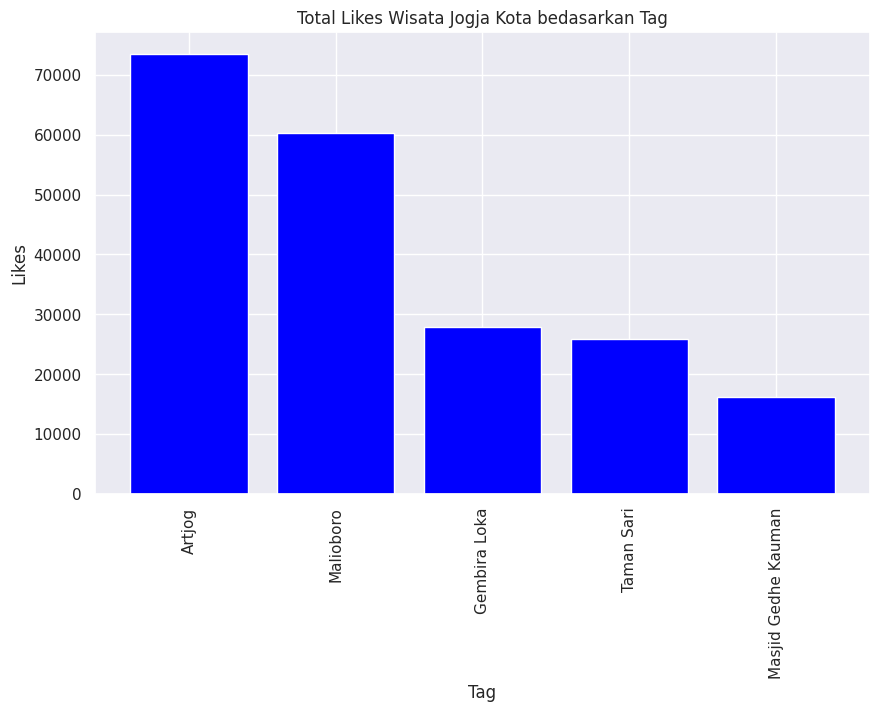

In [ ]:
# Select the top 5 tags by likes
dflikes= dflikes.nlargest(5, 'likes')


plt.figure(figsize=(10,6))
plt.bar(dflikes.index, dflikes['likes'], color='blue')
plt.title('Total Likes Wisata Jogja Kota bedasarkan Tag')
plt.xlabel('Tag')
plt.ylabel('Likes')
plt.xticks(rotation=90)

# Show the plot
plt.show()


###**6. Sentiment Analisis**




> **Sentimen dengan Transformer**





> Library Transformer akan digunakan untuk melatih model Machine Learning, khususnya untuk data berupa urutan atau teks. Model Transformer bekerja dengan memproses input secara paralel, menghilangkan kebutuhan untuk mengolah input secara berurutan. Mekanisme Attention, yang memungkinkan model fokus pada bagian penting dari input terkait dengan tugas yang harus diselesaikan, menjadi inti dari operasinya.

> Komponen utama dari model Transformer mencakup **Encoder**, yang bertugas mengubah input menjadi representasi laten, dan **Decoder**, yang menghasilkan output. Attention mechanism menjadi elemen kunci yang memungkinkan model berfokus pada bagian penting dari input terkait tugas.

> **DistilBERT**, yang dikembangkan oleh Hugging Face, adalah pilihan kita dalam library Transformer ini. Model ini merupakan versi ringkas dari BERT (Bidirectional Encoder Representations from Transformers) yang terkenal dalam dunia Natural Language Processing (NLP).



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=3)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



> Pada project ini, digunakan Dataset IndoNLU sebagai dataset fine-tuning. indoNLU (Indonesian Natural Language Understanding) adalah proyek open-source yang bertujuan untuk mengembangkan model pemahaman bahasa alami untuk bahasa Indonesia, yang menyediakan dataset untuk model pemahaman bahasa alami berbahasa Indonesia




In [ ]:
df_train = pd.read_csv('drive/MyDrive/BDA/train_preprocess.tsv', sep='\t', header=None)
df_test = pd.read_csv('drive/MyDrive/BDA/test_preprocess.tsv', sep='\t', header=None)

df_train.columns = ['text', 'label']
df_test.columns = ['text', 'label']

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [ ]:
df_train.sample(3)

,text,label
4426,tempat yang romantis dan dengan pemandangan ya...,negative
4053,ketika kami ingin mencari makanan khas jawa ba...,positive
5240,sebelum si zaadith cari perhatian sama jokowi ...,negative


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [ ]:
df_test.sample(3)

,text,label
254,sudahlah . ini negara demokrasi . jangan salin...,negative
407,"mouse logitech lucu-lucu desain nya , hampir s...",positive
3,ini pertama kalinya gua ke bank buat ngurusin ...,negative


In [ ]:
max_length = 512

In [ ]:
def sentiment_to_label(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0
    else:
        return 2

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df,tokenizer):
        self.encodings = tokenizer(df["text"].tolist(), truncation=True, padding=True)
        self.labels = df["label"].apply(sentiment_to_label).values

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = SentimentDataset(df_train, tokenizer)
test_dataset = SentimentDataset(df_test, tokenizer)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

> **Training Model**

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.25.0')

In [ ]:
training_args = TrainingArguments(
    output_dir='../model/',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=200,
    fp16=True,
)

In [ ]:
trainer = Trainer(model=model,  args=training_args, train_dataset=train_dataset,
                eval_dataset=test_dataset, tokenizer=tokenizer)

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
200,0.662100
400,0.429100
600,0.376500
800,0.295800
1000,0.223800
1200,0.235200
1400,0.217000
1600,0.130900
1800,0.127900
2000,0.132400


TrainOutput(global_step=3440, training_loss=0.18635388016700744, metrics={'train_runtime': 503.4426, 'train_samples_per_second': 109.248, 'train_steps_per_second': 6.833, 'total_flos': 2504506419360000.0, 'train_loss': 0.18635388016700744, 'epoch': 5.0})

In [ ]:
model.save_pretrained('../model/smsa-distilbert-indo/')
tokenizer.save_pretrained('../model/smsa-distilbert-indo/')

('../model/smsa-distilbert-indo/tokenizer_config.json',
 '../model/smsa-distilbert-indo/special_tokens_map.json',
 '../model/smsa-distilbert-indo/vocab.txt',
 '../model/smsa-distilbert-indo/added_tokens.json',
 '../model/smsa-distilbert-indo/tokenizer.json')

In [ ]:
config = AutoConfig.from_pretrained('../model/smsa-distilbert-indo/', label2id={"negative":0,"positive":1,"neutral":2}, id2label={0:"negative",1:"positive",2:"neutral"})
model = AutoModelForSequenceClassification.from_pretrained('../model/smsa-distilbert-indo/', config=config).to(device)
tokenizer = AutoTokenizer.from_pretrained('../model/smsa-distilbert-indo/')
model.save_pretrained('../model/smsa-distilbert-indo/')



> **Testing hasil model**



In [ ]:
predict = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

In [ ]:
predict("saya suka produk ini")

[{'label': 'positive', 'score': 0.9997472167015076}]

In [ ]:
predict("ini adalah candi prambanan")

[{'label': 'neutral', 'score': 0.9991806149482727}]

In [ ]:
predict("saya malas ke pantai")

[{'label': 'negative', 'score': 0.9985373020172119}]



> **Menghitung Akurasi, Presisi, dan Recall Model Hasil Train**



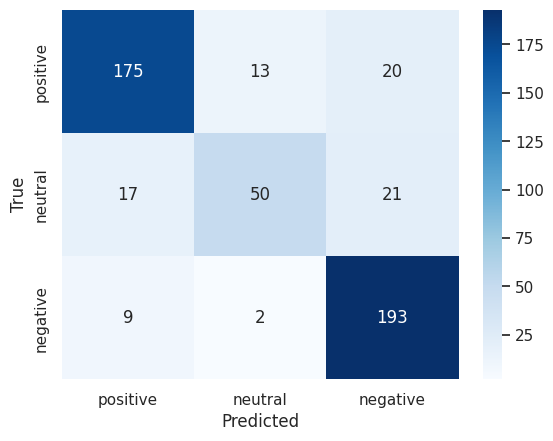

In [ ]:
from sklearn.metrics import confusion_matrix

# Train your model on the train dataset and make predictions on the test dataset
df_test_predict=df_test.copy()
df_test_predict.drop(['label'], axis=1, inplace=True)
df_test_predict['label_predict'] = ""
for ind in df_test_predict.index:
  temp_predict = predict(df_test_predict['text'][ind])[0]
  df_test_predict['label_predict'][ind] = temp_predict['label']

pred_labels = df_test_predict['label_predict'].values
true_labels = df_test['label'].values
labels = ["positive", "neutral", "negative"]

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels,labels=labels)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
accuracy = sum([cm[i][i] for i in range(len(labels))]) / float(len(true_labels))

precision = []
recall = []
for i in range(len(labels)):
    tp = cm[i][i]
    fp = sum(cm[:, i]) - tp
    fn = sum(cm[i, :]) - tp
    precision.append(tp / float(tp + fp))
    recall.append(tp / float(tp + fn))

In [ ]:
print('Accuracy:', accuracy, "\n")

for i in range(len(labels)):
    print('Precision for class', labels[i], ':', precision[i])
    print('Recall for class', labels[i], ':', recall[i], "\n")

Accuracy: 0.836 

Precision for class positive : 0.8706467661691543
Recall for class positive : 0.8413461538461539 

Precision for class neutral : 0.7692307692307693
Recall for class neutral : 0.5681818181818182 

Precision for class negative : 0.8247863247863247
Recall for class negative : 0.946078431372549 





> Dalam analisis sentimen biner (mis., mengklasifikasikan ulasan film sebagai positif atau negatif), akurasi 80% atau lebih sering dianggap baik. Namun, untuk tugas yang lebih kompleks yang melibatkan beberapa kategori sentimen (mis., mengklasifikasikan umpan balik pelanggan menjadi positif, negatif, dan netral), ambang akurasi yang baik mungkin lebih rendah.

> Dengan kata lain akurasi model hasil train pada projek ini sebesar 83.6% sudah dapat dianggap sebagai model yang cukup baik dalam melakukan analisis sentimen






**Implementasi**



In [ ]:
# Mengambil contoh tweet yang mengandung tag
dfjogjawis_filtered = dfjogjawis[dfjogjawis['taglist'].isin(listWisata)]

In [ ]:
dfjogjawis_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3204 entries, 4 to 19559
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         3204 non-null   int64              
 1   likes      3204 non-null   int64              
 2   source     3204 non-null   object             
 3   tweet      3204 non-null   object             
 4   date_time  3204 non-null   datetime64[ns, UTC]
 5   taglist    3204 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 175.2+ KB


In [ ]:
dfjogjawis_filtered.head(5)

,id,likes,source,tweet,date_time,taglist
4,4,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-01-29 16:00:00+00:00,[kebun]
6,6,1,Awtoshare,jelajah wisata jogja yuk jelajah tempat wisa...,2022-01-29 16:00:00+00:00,[goa]
34,34,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-01-29 04:00:00+00:00,[kebun]
41,41,1,Awtoshare,jelajah wisata jogja yuk jelajah tempat wisa...,2022-01-29 01:00:00+00:00,[bukit]
48,48,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-01-28 19:00:00+00:00,[kebun]


> **Implementasi Model Machine Learning**

In [ ]:
#Membuat kolom baru dfjogjawis_filtered
dfjogjawis_filtered['sentiment'] = ""

for ind in dfjogjawis_filtered.index:
  temp = predict(dfjogjawis_filtered['tweet'][ind])[0]
  dfjogjawis_filtered['sentiment'][ind] = temp['label']

In [ ]:
dfjogjawis_filtered.head(10)

,id,likes,source,tweet,date_time,taglist,sentiment
4,4,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-01-29 16:00:00+00:00,[kebun],neutral
6,6,1,Awtoshare,jelajah wisata jogja yuk jelajah tempat wisa...,2022-01-29 16:00:00+00:00,[goa],positive
34,34,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-01-29 04:00:00+00:00,[kebun],neutral
41,41,1,Awtoshare,jelajah wisata jogja yuk jelajah tempat wisa...,2022-01-29 01:00:00+00:00,[bukit],positive
48,48,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-01-28 19:00:00+00:00,[kebun],neutral
49,49,0,CatperkuNextScriptsAutoPoster,pantai di gunungkidul jogja wajib kunjung,2022-01-28 19:00:00+00:00,[pantai],neutral
50,50,0,Awtoshare,pantai di gunungkidul jogja wajib kunjung,2022-01-28 19:00:00+00:00,[pantai],neutral
64,64,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-01-28 13:00:00+00:00,[kebun],neutral
70,70,0,Twitter for Android,selain candi borobudur wisata jogja apa lg b...,2022-01-28 08:00:00+00:00,[candi],neutral
74,74,0,CatperkuNextScriptsAutoPoster,pantai baron pantai di jogja yang keren banget...,2022-01-28 05:00:00+00:00,[pantai],positive


In [ ]:
#Membuat kolom baru
dfwisata['sentiment'] = ""

for ind in dfwisata.index:
  temp = predict(dfwisata['tweet'][ind])[0]
  dfwisata['sentiment'][ind] = temp['label']

In [ ]:
dfwisata.head(10)

,id,likes,source,tweet,tag,date_time,sentiment
0,1,1,Twitter for Android,rabu melaksanakan kegiatan pendampingan penge...,Bangsal Kencana,2022-12-22 03:00:00+00:00,neutral
1,2,0,Twitter for Android,plusminusdua pameran nya cuma dikit kok kayak ...,Bangsal Kencana,2022-10-31 08:00:00+00:00,negative
2,3,2,Twitter for Android,didalam cepuri kotagedhe terdapat beberapa ban...,Bangsal Kencana,2022-10-18 09:00:00+00:00,neutral
3,4,1,Twitter Web App,regol gapuraregol gapura merupakan gerbang den...,Bangsal Kencana,2022-10-04 08:00:00+00:00,neutral
4,5,175,Twitter for Android,convomfs mamaku sih yg cerita wktu papaku dira...,Bangsal Kencana,2022-07-01 06:00:00+00:00,negative
5,6,1,Twitter for Android,presiden juga menyaksikan pementasan beksan la...,Bangsal Kencana,2022-06-20 05:00:00+00:00,neutral
6,7,0,detikcommunity,bangsal kencana pusat pemerintahan keraton yog...,Bangsal Kencana,2022-05-20 09:00:00+00:00,neutral
7,8,4,Twitter Web App,senin i nyoman budi satriya luhkan mataram me...,Bangsal Kencana,2022-04-18 08:00:00+00:00,neutral
8,9,0,Twitter for Android,senin i nyoman budi luhkan kec sekarbela mela...,Bangsal Kencana,2022-03-07 15:00:00+00:00,neutral
9,10,0,Instagram,setiap ahad akan menjadi rutinitas tersendiri ...,Bangsal Magangan,2022-07-31 07:00:00+00:00,neutral


### **Insight**

1. Tweets Positif Terkait Wisata Kota Jogja dengan Likes Terbanyak

In [ ]:
# calculate the total likes of each tag value
dflikes_sum = dfwisata.loc[dfwisata['sentiment'] == 'positive'].groupby(["tag"]).sum()
dflikes_sum['likes'] = dflikes_sum.groupby(["tag"]).mean()['likes']
dflikes_sum.drop(['id'], axis=1, inplace=True)
dflikes_sum = dflikes_sum.sort_values('likes', ascending=False)
# Select the top 5 tags by likes
dflikes_sum= dflikes_sum.nlargest(5, 'likes')


# calculate the mean of likes of each tag value
dflikes_mean = dfwisata.loc[dfwisata['sentiment'] == 'positive'].groupby(["tag"]).mean()
dflikes_mean['likes'] = dflikes_mean.groupby(["tag"]).mean()['likes']
dflikes_mean.drop(['id'], axis=1, inplace=True)
dflikes_mean = dflikes_mean.sort_values('likes', ascending=False)
# Select the top 5 tags by likes
dflikes_mean= dflikes_mean.nlargest(5, 'likes')

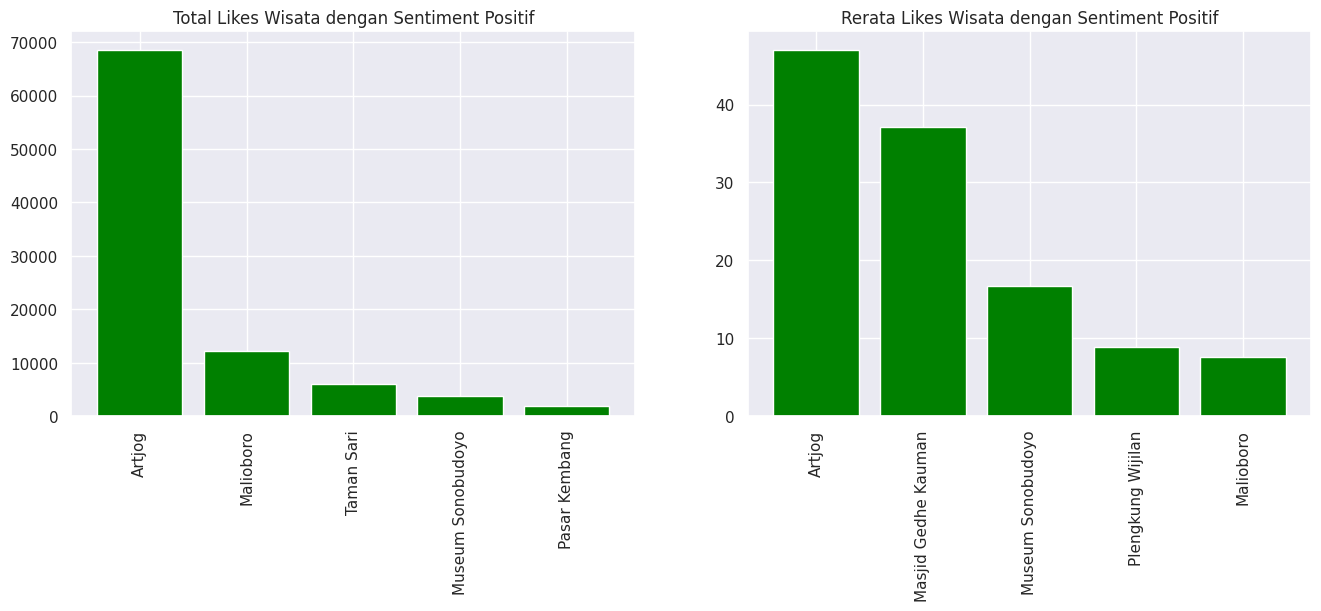

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Create a bar plot of the total likes
axs[0].bar(dflikes_sum.index, dflikes_sum['likes'], color='green')
axs[0].set_title('Total Likes Wisata dengan Sentiment Positif')
axs[0].set_xticklabels(dflikes_sum.index, rotation=90)


# Create a bar plot of the mean of likes
axs[1].bar(dflikes_mean.index, dflikes_mean['likes'], color='green')
axs[1].set_title('Rerata Likes Wisata dengan Sentiment Positif')
axs[1].set_xticklabels(dflikes_mean.index, rotation=90)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2)

# show the plot
plt.show()

2. Tweets Negatif Terkait Wisata Kota Jogja dengan Likes Terbanyak

In [ ]:
# calculate the total likes of each tag value
dflikes_sum = dfwisata.loc[dfwisata['sentiment'] == 'negative'].groupby(["tag"]).sum()
dflikes_sum['likes'] = dflikes_sum.groupby(["tag"]).mean()['likes']
dflikes_sum.drop(['id'], axis=1, inplace=True)
dflikes_sum = dflikes_sum.sort_values('likes', ascending=False)
# Select the top 5 tags by likes
dflikes_sum= dflikes_sum.nlargest(5, 'likes')


# calculate the mean of likes of each tag value
dflikes_mean = dfwisata.loc[dfwisata['sentiment'] == 'negative'].groupby(["tag"]).mean()
dflikes_mean['likes'] = dflikes_mean.groupby(["tag"]).mean()['likes']
dflikes_mean.drop(['id'], axis=1, inplace=True)
dflikes_mean = dflikes_mean.sort_values('likes', ascending=False)
# Select the top 5 tags by likes
dflikes_mean= dflikes_mean.nlargest(5, 'likes')

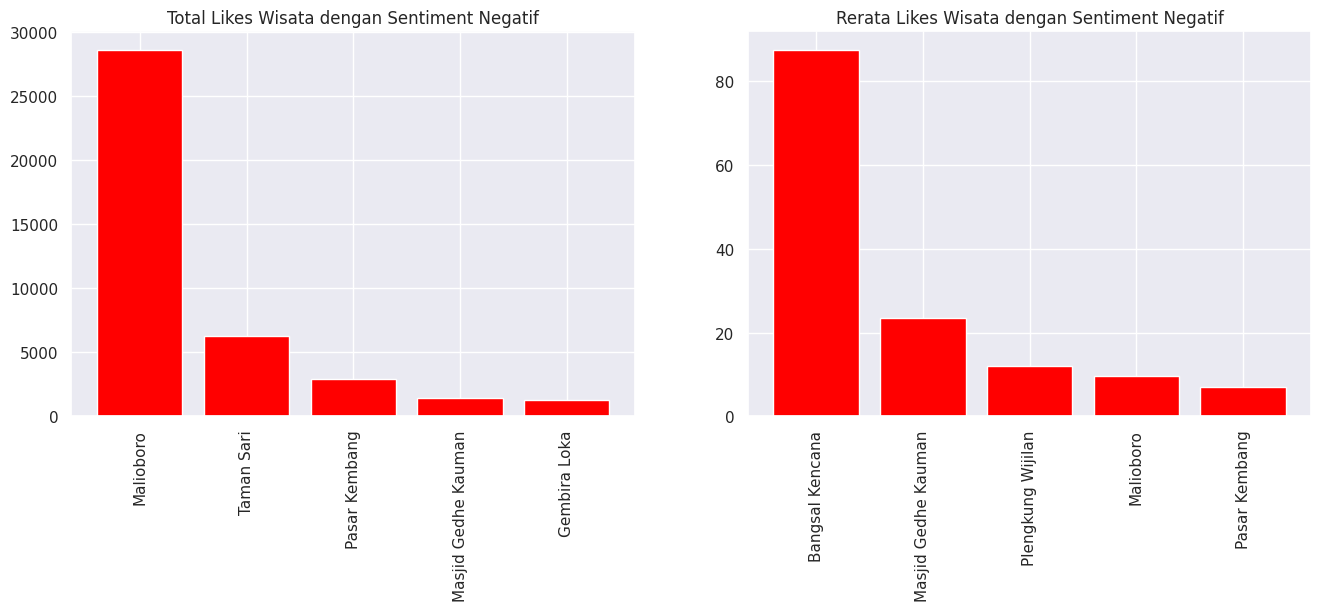

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Create a bar plot of the total likes
axs[0].bar(dflikes_sum.index, dflikes_sum['likes'], color='red')
axs[0].set_title('Total Likes Wisata dengan Sentiment Negatif')
axs[0].set_xticklabels(dflikes_sum.index, rotation=90)


# Create a bar plot of the mean of likes
axs[1].bar(dflikes_mean.index, dflikes_mean['likes'], color='red')
axs[1].set_title('Rerata Likes Wisata dengan Sentiment Negatif')
axs[1].set_xticklabels(dflikes_mean.index, rotation=90)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2)

# show the plot
plt.show()



> **Berdasarkan Hasil diatas, dapat disimpulkan bahwa:**



> Destinasi wisata di Jogja memiliki karakteristik yang beragam dari segi sentimen yang terpancar melalui platform media sosial. Beberapa temuan menarik termasuk kesuksesan **Artjog** yang menduduki peringkat pertama dalam total likes dari tweets positif dan dalam rata-rata likes dari tweets positif, sementara tidak muncul dalam urutan lima besar untuk tweets negatif.

> Di sisi lain, **Bangsal Kencana** mencuat sebagai destinasi yang menerima banyak likes untuk tweets dengan sentimen negatif, menunjukkan bahwa masih ada area yang dapat diperbaiki atau dikelola dengan lebih baik.

> **Museum Sonoboyo**, **Masjid Gedhe Kauman**, dan **Malioboro** menunjukkan variasi yang menarik, dengan jumlah rata-rata likes yang signifikan untuk kedua sentimen. Namun, perlu diperhatikan bahwa **Museum Sonoboyo** dan **Masjid Gedhe Kauman** cenderung lebih positif, sedangkan **Malioboro** cenderung lebih negatif.




### **Kesimpulan**

> Sebagai kesimpulan, kita berharap agar pihak terkait dan masyarakat dapat menggunakan analisis ini sebagai panduan untuk meningkatkan kualitas dan pengelolaan destinasi wisata di Kota Jogja. Dengan fokus pada penyediaan pengalaman wisata yang positif, penanganan permasalahan, dan pemanfaatan media sosial sebagai alat promosi yang lebih efektif, diharapkan Kota Jogja dapat terus menjadi destinasi yang menarik dan menyenangkan bagi pengunjung.